In [1]:
import pickle
import numpy as np
import numpy.matlib as mt
from matplotlib import pyplot as plt
from scipy import signal,stats
# from ephysvibe.structures.neuron_data import NeuronData
# from ephysvibe.trials import align_trials
# from ephysvibe.task import task_constants
import os 
import glob


from sklearn import metrics

In [2]:
with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/ROCanalyses/LIPsampleROC', 'rb') as handle:
    lip = pickle.load(handle)

with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/ROCanalyses/PFCsampleROC', 'rb') as handle:
    pfc = pickle.load(handle)    

with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/ROCanalyses/V4sampleROC', 'rb') as handle:
    v4 = pickle.load(handle)        

In [3]:
def definelatencies(p_values, win, threshold):

   lat=[]

   for i in np.arange(p_values.shape[0]):
      
      tmp=[]
      
      sig=np.zeros(p_values.shape[1])
      sig[np.where(p_values[i,:]<0.01)]=1
      

      for i_step in np.arange(sig.shape[0]):
         if sig[i_step]==1 and np.sum(sig[i_step:i_step+win])>=threshold:
            tmp.append(i_step)  

      if not tmp:
         lat.append(np.nan)  
      else:
         lat.append(tmp[0])  
      
   lat=np.array(lat)

   return lat


In [4]:
def moving_average(data:np.ndarray,win:int, step:int=1)-> np.ndarray:
    d_shape=data.shape
    d_avg = np.zeros((d_shape[0],int(np.floor(d_shape[1]/step))))
    count = 0
    for i_step in np.arange(0,d_shape[1]-step,step):
        d_avg[:,count] = np.mean(data[:,i_step:i_step+win],axis=1)
        count +=1
    return d_avg

In [4]:
def sortrocvaluesbylatencies(values,lat, select):
    
    sig_cells       =   np.where(lat>=0)[0]
    nonsig_cells    =   np.where(np.isnan(lat))[0]

    pos_sig_cells=sig_cells[np.mean(values[sig_cells,:], axis=1)>=0]
    neg_sig_cells=sig_cells[np.mean(values[sig_cells,:], axis=1)<0]

    sortpos_sig=np.argsort(lat[pos_sig_cells])
    sortneg_sig=np.argsort(lat[neg_sig_cells])
    sorted_index=np.concatenate([neg_sig_cells[sortneg_sig], nonsig_cells, pos_sig_cells[sortpos_sig[::-1]]])

    sig_cells       =   select[lat[select]>=0]
    nonsig_cells    =   select[np.isnan(lat[select])]

    pos_sig_cells=sig_cells[np.mean(values[sig_cells,:], axis=1)>=0]
    neg_sig_cells=sig_cells[np.mean(values[sig_cells,:], axis=1)<0]

    sortpos_sig=np.argsort(lat[pos_sig_cells])
    sortneg_sig=np.argsort(lat[neg_sig_cells])
    sorted_index_selected=np.concatenate([neg_sig_cells[sortneg_sig], nonsig_cells, pos_sig_cells[sortpos_sig[::-1]]])

    return sorted_index, sorted_index_selected
               

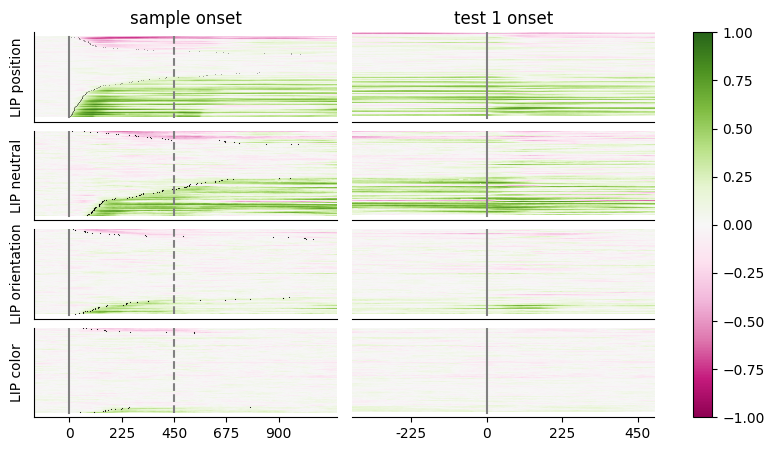

In [5]:
lip_neutral_sample_value    =   lip['sample_s_ROC_values']['ROC value sample neutral']
lip_neutral_test_value      =   lip['sample_t_ROC_values']['ROC value t1 neutral']

lip_orient_sample_value     =   lip['sample_s_ROC_values']['ROC value sample orient']
lip_orient_test_value       =   lip['sample_t_ROC_values']['ROC value T1 orient']

lip_color_sample_value      =   lip['sample_s_ROC_values']['ROC value sample color']
lip_color_test_value        =   lip['sample_t_ROC_values']['ROC value T1 color']

lip_position_sample_value   =   lip['sample_s_ROC_values']['ROC value sample position']
lip_position_test_value     =   lip['sample_t_ROC_values']['ROC value T1 position']

# lip_neutral_sample_value[np.sum(lip_position_sample_value, axis=1)>0]

lat_lip_neutral     =   lip['sample_latencies']['lat_neutral']
lat_lip_orient      =   lip['sample_latencies']['lat_orient']
lat_lip_color       =   lip['sample_latencies']['lat_color']
lat_lip_position    =   lip['sample_latencies']['lat_pos']

lat_lip_position[lat_lip_position>1200]=np.nan
lat_lip_neutral[lat_lip_neutral>1200]=np.nan
lat_lip_orient[lat_lip_orient>1200]=np.nan
lat_lip_color[lat_lip_color>1200]=np.nan

select=np.where(lip['mean response']>5)[0]
select_lip=select

sort_sneutral, sort_sneutral_select     =   sortrocvaluesbylatencies(lip_neutral_sample_value[:,200:700],lat_lip_neutral, select)
sort_sorient, sort_sorient_select       =   sortrocvaluesbylatencies(lip_orient_sample_value[:,200:700],lat_lip_orient, select)
sort_scolor, sort_scolor_select         =   sortrocvaluesbylatencies(lip_color_sample_value[:,200:700],lat_lip_color, select)
sort_sposition, sort_sposition_select   =   sortrocvaluesbylatencies(lip_position_sample_value[:,200:700],lat_lip_position, select)

sort_tneutral    =   np.argsort(np.mean(lip_neutral_test_value[:,450:900], axis=1))
sort_torient     =   np.argsort(np.mean(lip_orient_test_value[:,450:900], axis=1))
sort_tcolor      =   np.argsort(np.mean(lip_color_test_value[:,450:900], axis=1))
sort_tposition   =   np.argsort(np.mean(lip_position_test_value[:,450:900], axis=1))

sort_neutral    =   sort_sneutral_select
sort_orient     =   sort_sorient_select
sort_color      =   sort_scolor_select
sort_position   =   sort_sposition_select

# fig     =   plt.figure(figsize=(10,10))
fig, ax      =   plt.subplots(4,2,figsize=(10,5))

# im0       =   sns.heatmap(lip_position_sample_value[sort_position,:1300], vmin=-1, vmax=1, cmap='PiYG', ax=ax[0,0])#
im0       =   ax[0,0].imshow(lip_position_sample_value[sort_position,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto', interpolation='bilinear')
im1       =   ax[0,1].imshow(lip_position_test_value[sort_position,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

im2       =   ax[1,0].imshow(lip_neutral_sample_value[sort_neutral,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im3       =   ax[1,1].imshow(lip_neutral_test_value[sort_neutral,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

im4       =   ax[2,0].imshow(lip_orient_sample_value[sort_orient,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im5       =   ax[2,1].imshow(lip_orient_test_value[sort_orient,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

im6       =   ax[3,0].imshow(lip_color_sample_value[sort_color,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im7       =   ax[3,1].imshow(lip_color_test_value[sort_color,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

ax[0,0].scatter(lat_lip_position[sort_position], np.arange(sort_position.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=0.1)
ax[1,0].scatter(lat_lip_neutral[sort_neutral], np.arange(sort_neutral.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=0.5)
ax[2,0].scatter(lat_lip_orient[sort_orient], np.arange(sort_orient.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=.5)
ax[3,0].scatter(lat_lip_color[sort_color], np.arange(sort_color.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=.5)

# ax[0,0].plot([lat_lip_position[sort_position], lat_lip_position[sort_position]], [np.arange(lat_lip_position.shape[0])-.5, np.arange(lat_lip_position.shape[0])+0.5], color=[0, 0, 0], linewidth=1)
# ax[1,0].plot([lat_lip_neutral[sort_neutral], lat_lip_neutral[sort_neutral]], [np.arange(lat_lip_neutral.shape[0])-.5, np.arange(lat_lip_neutral.shape[0])+.5], color=[0, 0, 0], linewidth=1)
# ax[2,0].plot([lat_lip_orient[sort_orient], lat_lip_orient[sort_orient]], [np.arange(lat_lip_orient.shape[0])-.5, np.arange(lat_lip_orient.shape[0])+.5], color=[0, 0, 0], linewidth=1)
# ax[3,0].plot([lat_lip_color[sort_color], lat_lip_color[sort_color]], [np.arange(lat_lip_color.shape[0])-.5, np.arange(lat_lip_color.shape[0])+.5], color=[0, 0, 0], linewidth=1)

ax[0,0].plot([150,150],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))
ax[1,0].plot([150,150],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))
ax[2,0].plot([150,150],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))
ax[3,0].plot([150,150],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))

ax[0,0].plot([150+450,150+450],[-1, sort_neutral.shape[0]+2],color=(0.5, .5, .5),linestyle='dashed')
ax[1,0].plot([150+450,150+450],[0, sort_neutral.shape[0]],color=(0.5, .5, .5),linestyle='dashed')
ax[2,0].plot([150+450,150+450],[0, sort_neutral.shape[0]],color=(0.5, .5, .5), linestyle='dashed')
ax[3,0].plot([150+450,150+450],[0, sort_neutral.shape[0]],color=(0.5, .5, .5), linestyle='dashed')

ax[0,1].plot([400,400],[2, sort_neutral.shape[0]+2],color=(0.5, .5, .5))
ax[1,1].plot([400,400],[0, sort_neutral.shape[0]+1],color=(0.5, .5, .5))
ax[2,1].plot([400,400],[0, sort_neutral.shape[0]+1],color=(0.5, .5, .5))
ax[3,1].plot([400,400],[0, sort_neutral.shape[0]+1],color=(0.5, .5, .5))

ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_title('sample onset')
ax[0,0].set_ylabel('LIP position')
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)

ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_title('test 1 onset')
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)

ax[1,0].set_xticks([])
ax[1,0].set_yticks([])

ax[1,0].set_ylabel('LIP neutral')
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)

ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)

ax[2,0].set_xticks([])
ax[2,0].set_yticks([])
ax[2,0].set_ylabel('LIP orientation')
ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)

ax[2,1].set_xticks([])
ax[2,1].set_yticks([])
ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)

ax[3,0].set_xticks([150+225*(0), 150+225*(1), 150+225*(2), 150+225*(3), 150+225*(4)])
ax[3,0].set_xticklabels(['0', '225', '450', '675', '900'])
ax[3,0].set_yticks([])
ax[3,0].set_ylabel('LIP color')
ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)

ax[3,1].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2)])
ax[3,1].set_xticklabels(['-225', '0', '225', '450'])
ax[3,1].set_yticks([])
ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)

fig.subplots_adjust(wspace=0.05, hspace=0.1)
fig.colorbar(im2, ax=ax)

# plt.savefig('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/figures/ROC_lip5.pdf')  

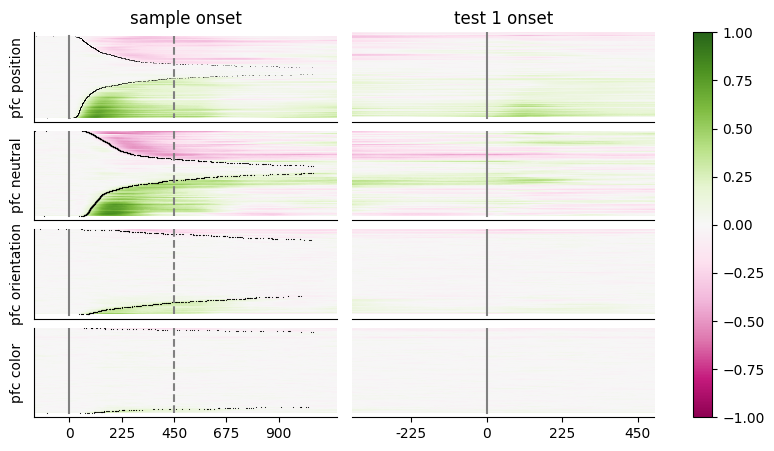

In [6]:
pfc_neutral_sample_value    =   pfc['sample_s_ROC_values']['ROC value sample neutral']
pfc_neutral_test_value      =   pfc['sample_t_ROC_values']['ROC value t1 neutral']

pfc_orient_sample_value     =   pfc['sample_s_ROC_values']['ROC value sample orient']
pfc_orient_test_value       =   pfc['sample_t_ROC_values']['ROC value T1 orient']

pfc_color_sample_value      =   pfc['sample_s_ROC_values']['ROC value sample color']
pfc_color_test_value        =   pfc['sample_t_ROC_values']['ROC value T1 color']

pfc_position_sample_value   =   pfc['sample_s_ROC_values']['ROC value sample position']
pfc_position_test_value     =   pfc['sample_t_ROC_values']['ROC value T1 position']

# pfc_neutral_sample_value[np.sum(pfc_position_sample_value, axis=1)>0]

lat_pfc_neutral     =   pfc['sample_latencies']['lat_neutral']
lat_pfc_orient      =   pfc['sample_latencies']['lat_orient']
lat_pfc_color       =   pfc['sample_latencies']['lat_color']
lat_pfc_position    =   pfc['sample_latencies']['lat_pos']

lat_pfc_position[lat_pfc_position>1200]=np.nan
lat_pfc_neutral[lat_pfc_neutral>1200]=np.nan
lat_pfc_orient[lat_pfc_orient>1200]=np.nan
lat_pfc_color[lat_pfc_color>1200]=np.nan

select=np.where(pfc['mean response']>5)[0]
select_pfc=select
sort_sneutral, sort_sneutral_select     =   sortrocvaluesbylatencies(pfc_neutral_sample_value[:,200:700],lat_pfc_neutral, select)
sort_sorient, sort_sorient_select       =   sortrocvaluesbylatencies(pfc_orient_sample_value[:,200:700],lat_pfc_orient, select)
sort_scolor, sort_scolor_select         =   sortrocvaluesbylatencies(pfc_color_sample_value[:,200:700],lat_pfc_color, select)
sort_sposition, sort_sposition_select   =   sortrocvaluesbylatencies(pfc_position_sample_value[:,200:700],lat_pfc_position, select)

sort_tneutral    =   np.argsort(np.mean(pfc_neutral_test_value[:,450:900], axis=1))
sort_torient     =   np.argsort(np.mean(pfc_orient_test_value[:,450:900], axis=1))
sort_tcolor      =   np.argsort(np.mean(pfc_color_test_value[:,450:900], axis=1))
sort_tposition   =   np.argsort(np.mean(pfc_position_test_value[:,450:900], axis=1))

sort_neutral    =   sort_sneutral_select
sort_orient     =   sort_sorient_select
sort_color      =   sort_scolor_select
sort_position   =   sort_sposition_select

# fig     =   plt.figure(figsize=(10,10))
fig, ax      =   plt.subplots(4,2,figsize=(10,5))

# im0       =   sns.heatmap(pfc_position_sample_value[sort_position,:1300], vmin=-1, vmax=1, cmap='PiYG', ax=ax[0,0])#
im0       =   ax[0,0].imshow(pfc_position_sample_value[sort_position,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto', interpolation='bilinear')
im1       =   ax[0,1].imshow(pfc_position_test_value[sort_position,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

im2       =   ax[1,0].imshow(pfc_neutral_sample_value[sort_neutral,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im3       =   ax[1,1].imshow(pfc_neutral_test_value[sort_neutral,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

im4       =   ax[2,0].imshow(pfc_orient_sample_value[sort_orient,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im5       =   ax[2,1].imshow(pfc_orient_test_value[sort_orient,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

im6       =   ax[3,0].imshow(pfc_color_sample_value[sort_color,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im7       =   ax[3,1].imshow(pfc_color_test_value[sort_color,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

ax[0,0].scatter(lat_pfc_position[sort_position], np.arange(sort_position.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=0.1)
ax[1,0].scatter(lat_pfc_neutral[sort_neutral], np.arange(sort_neutral.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=0.5)
ax[2,0].scatter(lat_pfc_orient[sort_orient], np.arange(sort_orient.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=.5)
ax[3,0].scatter(lat_pfc_color[sort_color], np.arange(sort_color.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=.5)

# ax[0,0].plot([lat_pfc_position[sort_position], lat_pfc_position[sort_position]], [np.arange(lat_pfc_position.shape[0])-.5, np.arange(lat_pfc_position.shape[0])+0.5], color=[0, 0, 0], linewidth=1)
# ax[1,0].plot([lat_pfc_neutral[sort_neutral], lat_pfc_neutral[sort_neutral]], [np.arange(lat_pfc_neutral.shape[0])-.5, np.arange(lat_pfc_neutral.shape[0])+.5], color=[0, 0, 0], linewidth=1)
# ax[2,0].plot([lat_pfc_orient[sort_orient], lat_pfc_orient[sort_orient]], [np.arange(lat_pfc_orient.shape[0])-.5, np.arange(lat_pfc_orient.shape[0])+.5], color=[0, 0, 0], linewidth=1)
# ax[3,0].plot([lat_pfc_color[sort_color], lat_pfc_color[sort_color]], [np.arange(lat_pfc_color.shape[0])-.5, np.arange(lat_pfc_color.shape[0])+.5], color=[0, 0, 0], linewidth=1)

ax[0,0].plot([150,150],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))
ax[1,0].plot([150,150],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))
ax[2,0].plot([150,150],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))
ax[3,0].plot([150,150],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))

ax[0,0].plot([150+450,150+450],[-1, sort_neutral.shape[0]+2],color=(0.5, .5, .5),linestyle='dashed')
ax[1,0].plot([150+450,150+450],[0, sort_neutral.shape[0]],color=(0.5, .5, .5),linestyle='dashed')
ax[2,0].plot([150+450,150+450],[0, sort_neutral.shape[0]],color=(0.5, .5, .5), linestyle='dashed')
ax[3,0].plot([150+450,150+450],[0, sort_neutral.shape[0]],color=(0.5, .5, .5), linestyle='dashed')

ax[0,1].plot([400,400],[2, sort_neutral.shape[0]+2],color=(0.5, .5, .5))
ax[1,1].plot([400,400],[0, sort_neutral.shape[0]+1],color=(0.5, .5, .5))
ax[2,1].plot([400,400],[0, sort_neutral.shape[0]+1],color=(0.5, .5, .5))
ax[3,1].plot([400,400],[0, sort_neutral.shape[0]+1],color=(0.5, .5, .5))

ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_title('sample onset')
ax[0,0].set_ylabel('pfc position')
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)

ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_title('test 1 onset')
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)

ax[1,0].set_xticks([])
ax[1,0].set_yticks([])

ax[1,0].set_ylabel('pfc neutral')
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)

ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)

ax[2,0].set_xticks([])
ax[2,0].set_yticks([])
ax[2,0].set_ylabel('pfc orientation')
ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)

ax[2,1].set_xticks([])
ax[2,1].set_yticks([])
ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)

ax[3,0].set_xticks([150+225*(0), 150+225*(1), 150+225*(2), 150+225*(3), 150+225*(4)])
ax[3,0].set_xticklabels(['0', '225', '450', '675', '900'])
ax[3,0].set_yticks([])
ax[3,0].set_ylabel('pfc color')
ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)

ax[3,1].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2)])
ax[3,1].set_xticklabels(['-225', '0', '225', '450'])
ax[3,1].set_yticks([])
ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)

fig.subplots_adjust(wspace=0.05, hspace=0.1)
fig.colorbar(im2, ax=ax)

# plt.savefig('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/figures/ROC_pfc5.pdf')  

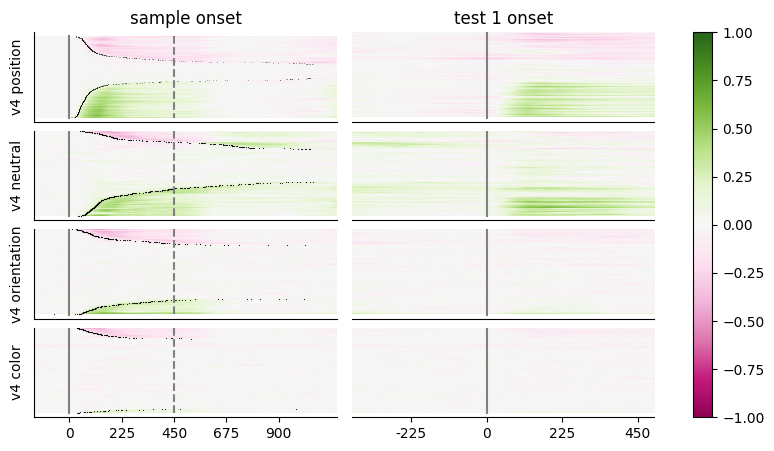

In [7]:
v4_neutral_sample_value    =   v4['sample_s_ROC_values']['ROC value sample neutral']
v4_neutral_test_value      =   v4['sample_t_ROC_values']['ROC value t1 neutral']

v4_orient_sample_value     =   v4['sample_s_ROC_values']['ROC value sample orient']
v4_orient_test_value       =   v4['sample_t_ROC_values']['ROC value T1 orient']

v4_color_sample_value      =   v4['sample_s_ROC_values']['ROC value sample color']
v4_color_test_value        =   v4['sample_t_ROC_values']['ROC value T1 color']

v4_position_sample_value   =   v4['sample_s_ROC_values']['ROC value sample position']
v4_position_test_value     =   v4['sample_t_ROC_values']['ROC value T1 position']

# v4_neutral_sample_value[np.sum(v4_position_sample_value, axis=1)>0]

lat_v4_neutral     =   v4['sample_latencies']['lat_neutral']
lat_v4_orient      =   v4['sample_latencies']['lat_orient']
lat_v4_color       =   v4['sample_latencies']['lat_color']
lat_v4_position    =   v4['sample_latencies']['lat_pos']

lat_v4_position[lat_v4_position>1200]=np.nan
lat_v4_neutral[lat_v4_neutral>1200]=np.nan
lat_v4_orient[lat_v4_orient>1200]=np.nan
lat_v4_color[lat_v4_color>1200]=np.nan

select=np.where(v4['mean response']>5)[0]
select_v4=select
sort_sneutral, sort_sneutral_select     =   sortrocvaluesbylatencies(v4_neutral_sample_value[:,200:700],lat_v4_neutral, select)
sort_sorient, sort_sorient_select       =   sortrocvaluesbylatencies(v4_orient_sample_value[:,200:700],lat_v4_orient, select)
sort_scolor, sort_scolor_select         =   sortrocvaluesbylatencies(v4_color_sample_value[:,200:700],lat_v4_color, select)
sort_sposition, sort_sposition_select   =   sortrocvaluesbylatencies(v4_position_sample_value[:,200:700],lat_v4_position, select)

sort_tneutral    =   np.argsort(np.mean(v4_neutral_test_value[:,450:900], axis=1))
sort_torient     =   np.argsort(np.mean(v4_orient_test_value[:,450:900], axis=1))
sort_tcolor      =   np.argsort(np.mean(v4_color_test_value[:,450:900], axis=1))
sort_tposition   =   np.argsort(np.mean(v4_position_test_value[:,450:900], axis=1))

sort_neutral    =   sort_sneutral_select
sort_orient     =   sort_sorient_select
sort_color      =   sort_scolor_select
sort_position   =   sort_sposition_select

# fig     =   plt.figure(figsize=(10,10))
fig, ax      =   plt.subplots(4,2,figsize=(10,5))

# im0       =   sns.heatmap(v4_position_sample_value[sort_position,:1300], vmin=-1, vmax=1, cmap='PiYG', ax=ax[0,0])#
im0       =   ax[0,0].imshow(v4_position_sample_value[sort_position,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto', interpolation='bilinear')
im1       =   ax[0,1].imshow(v4_position_test_value[sort_position,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

im2       =   ax[1,0].imshow(v4_neutral_sample_value[sort_neutral,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im3       =   ax[1,1].imshow(v4_neutral_test_value[sort_neutral,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

im4       =   ax[2,0].imshow(v4_orient_sample_value[sort_orient,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im5       =   ax[2,1].imshow(v4_orient_test_value[sort_orient,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

im6       =   ax[3,0].imshow(v4_color_sample_value[sort_color,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im7       =   ax[3,1].imshow(v4_color_test_value[sort_color,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

ax[0,0].scatter(lat_v4_position[sort_position], np.arange(sort_position.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=0.1)
ax[1,0].scatter(lat_v4_neutral[sort_neutral], np.arange(sort_neutral.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=0.5)
ax[2,0].scatter(lat_v4_orient[sort_orient], np.arange(sort_orient.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=.5)
ax[3,0].scatter(lat_v4_color[sort_color], np.arange(sort_color.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=.5)

# ax[0,0].plot([lat_v4_position[sort_position], lat_v4_position[sort_position]], [np.arange(lat_v4_position.shape[0])-.5, np.arange(lat_v4_position.shape[0])+0.5], color=[0, 0, 0], linewidth=1)
# ax[1,0].plot([lat_v4_neutral[sort_neutral], lat_v4_neutral[sort_neutral]], [np.arange(lat_v4_neutral.shape[0])-.5, np.arange(lat_v4_neutral.shape[0])+.5], color=[0, 0, 0], linewidth=1)
# ax[2,0].plot([lat_v4_orient[sort_orient], lat_v4_orient[sort_orient]], [np.arange(lat_v4_orient.shape[0])-.5, np.arange(lat_v4_orient.shape[0])+.5], color=[0, 0, 0], linewidth=1)
# ax[3,0].plot([lat_v4_color[sort_color], lat_v4_color[sort_color]], [np.arange(lat_v4_color.shape[0])-.5, np.arange(lat_v4_color.shape[0])+.5], color=[0, 0, 0], linewidth=1)

ax[0,0].plot([150,150],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))
ax[1,0].plot([150,150],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))
ax[2,0].plot([150,150],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))
ax[3,0].plot([150,150],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))

ax[0,0].plot([150+450,150+450],[-1, sort_neutral.shape[0]+2],color=(0.5, .5, .5),linestyle='dashed')
ax[1,0].plot([150+450,150+450],[0, sort_neutral.shape[0]],color=(0.5, .5, .5),linestyle='dashed')
ax[2,0].plot([150+450,150+450],[0, sort_neutral.shape[0]],color=(0.5, .5, .5), linestyle='dashed')
ax[3,0].plot([150+450,150+450],[0, sort_neutral.shape[0]],color=(0.5, .5, .5), linestyle='dashed')

ax[0,1].plot([400,400],[2, sort_neutral.shape[0]+2],color=(0.5, .5, .5))
ax[1,1].plot([400,400],[0, sort_neutral.shape[0]+1],color=(0.5, .5, .5))
ax[2,1].plot([400,400],[0, sort_neutral.shape[0]+1],color=(0.5, .5, .5))
ax[3,1].plot([400,400],[0, sort_neutral.shape[0]+1],color=(0.5, .5, .5))

ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_title('sample onset')
ax[0,0].set_ylabel('v4 position')
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)

ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_title('test 1 onset')
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)

ax[1,0].set_xticks([])
ax[1,0].set_yticks([])

ax[1,0].set_ylabel('v4 neutral')
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)

ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)

ax[2,0].set_xticks([])
ax[2,0].set_yticks([])
ax[2,0].set_ylabel('v4 orientation')
ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)

ax[2,1].set_xticks([])
ax[2,1].set_yticks([])
ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)

ax[3,0].set_xticks([150+225*(0), 150+225*(1), 150+225*(2), 150+225*(3), 150+225*(4)])
ax[3,0].set_xticklabels(['0', '225', '450', '675', '900'])
ax[3,0].set_yticks([])
ax[3,0].set_ylabel('v4 color')
ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)

ax[3,1].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2)])
ax[3,1].set_xticklabels(['-225', '0', '225', '450'])
ax[3,1].set_yticks([])
ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)

fig.subplots_adjust(wspace=0.05, hspace=0.1)
fig.colorbar(im2, ax=ax)

# plt.savefig('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/figures/ROC_v45.pdf')  

In [98]:
int(select_lip.shape[0]*2/3)

120

In [100]:
Num     =   int(select_lip.shape[0]*2/3)
Num_lip_cells   =   select_lip.shape[0]
Num_pfc_cells   =   select_pfc.shape[0]
Num_v4_cells    =   select_v4.shape[0]

lat_rand_v4_position    =   np.empty((1000,Num,))*np.nan
lat_rand_pfc_position   =   np.empty((1000,Num,))*np.nan
lat_rand_lip_position   =   np.empty((1000,Num,))*np.nan

lat_rand_v4_neutral     =   np.empty((1000,Num,))*np.nan
lat_rand_pfc_neutral    =   np.empty((1000,Num,))*np.nan
lat_rand_lip_neutral    =   np.empty((1000,Num,))*np.nan

lat_rand_v4_orient      =   np.empty((1000,Num,))*np.nan
lat_rand_pfc_orient     =   np.empty((1000,Num,))*np.nan
lat_rand_lip_orient     =   np.empty((1000,Num,))*np.nan

lat_rand_v4_color       =   np.empty((1000,Num,))*np.nan
lat_rand_pfc_color      =   np.empty((1000,Num,))*np.nan
lat_rand_lip_color      =   np.empty((1000,Num,))*np.nan

for j in range(1000):
    select_lip_cells    =    select_lip[np.random.choice(Num_lip_cells, Num, replace=False)]
    select_pfc_cells    =    select_pfc[np.random.choice(Num_pfc_cells, Num, replace=False)]
    select_v4_cells     =    select_v4[np.random.choice(Num_v4_cells, Num, replace=False)]

    lat_rand_lip_position[j,:]  =   lat_lip_position[select_lip_cells]  
    lat_rand_pfc_position[j,:]  =   lat_pfc_position[select_pfc_cells]
    lat_rand_v4_position[j,:]   =   lat_v4_position[select_v4_cells]

    lat_rand_lip_neutral[j,:]  =   lat_lip_neutral[select_lip_cells]
    lat_rand_pfc_neutral[j,:]  =   lat_pfc_neutral[select_pfc_cells]
    lat_rand_v4_neutral[j,:]   =   lat_v4_neutral[select_v4_cells]
    
    lat_rand_lip_orient[j,:]  =   lat_lip_orient[select_lip_cells]
    lat_rand_pfc_orient[j,:]  =   lat_pfc_orient[select_pfc_cells]
    lat_rand_v4_orient[j,:]   =   lat_v4_orient[select_v4_cells]
    
    lat_rand_lip_color[j,:]  =   lat_lip_color[select_lip_cells]
    lat_rand_pfc_color[j,:]  =   lat_pfc_color[select_pfc_cells]
    lat_rand_v4_color[j,:]   =   lat_v4_color[select_v4_cells]


    

In [14]:
lat_diff_lip_v4_position    =   np.reshape(mt.repmat(lat_rand_v4_position[0],lat_rand_v4_position[0].shape[0],1)-np.transpose(mt.repmat(lat_lip_position,lat_lip_position.shape[0],1)), [1, lat_lip_position.shape[0]*lat_lip_position.shape[0]])
lat_diff_lip_pfc_position   =   np.reshape(mt.repmat(lat_rand_pfc_position[0],lat_rand_pfc_position[0].shape[0],1)-np.transpose(mt.repmat(lat_lip_position,lat_lip_position.shape[0],1)), [1, lat_lip_position.shape[0]*lat_lip_position.shape[0]])
lat_diff_lip_v4_position    =   lat_diff_lip_v4_position[lat_diff_lip_v4_position>-3000]
lat_diff_lip_pfc_position   =   lat_diff_lip_pfc_position[lat_diff_lip_pfc_position>-3000]

lat_diff_lip_v4_neutral    =   np.reshape(mt.repmat(lat_rand_v4_neutral[0],lat_rand_v4_neutral[0].shape[0],1)-np.transpose(mt.repmat(lat_lip_neutral,lat_lip_neutral.shape[0],1)), [1, lat_lip_neutral.shape[0]*lat_lip_neutral.shape[0]])
lat_diff_lip_pfc_neutral   =   np.reshape(mt.repmat(lat_rand_pfc_neutral[0],lat_rand_pfc_neutral[0].shape[0],1)-np.transpose(mt.repmat(lat_lip_neutral,lat_lip_neutral.shape[0],1)), [1, lat_lip_neutral.shape[0]*lat_lip_neutral.shape[0]])
lat_diff_lip_v4_neutral    =   lat_diff_lip_v4_neutral[lat_diff_lip_v4_neutral>-3000]
lat_diff_lip_pfc_neutral   =   lat_diff_lip_pfc_neutral[lat_diff_lip_pfc_neutral>-3000]

lat_diff_lip_v4_orient    =   np.reshape(mt.repmat(lat_rand_v4_orient[0],lat_rand_v4_orient[0].shape[0],1)-np.transpose(mt.repmat(lat_lip_orient,lat_lip_orient.shape[0],1)), [1, lat_lip_orient.shape[0]*lat_lip_orient.shape[0]])
lat_diff_lip_pfc_orient   =   np.reshape(mt.repmat(lat_rand_pfc_orient[0],lat_rand_pfc_orient[0].shape[0],1)-np.transpose(mt.repmat(lat_lip_orient,lat_lip_orient.shape[0],1)), [1, lat_lip_orient.shape[0]*lat_lip_orient.shape[0]])
lat_diff_lip_v4_orient    =   lat_diff_lip_v4_orient[lat_diff_lip_v4_orient>-3000]
lat_diff_lip_pfc_orient   =   lat_diff_lip_pfc_orient[lat_diff_lip_pfc_orient>-3000]

lat_diff_lip_v4_color    =   np.reshape(mt.repmat(lat_rand_v4_color[0],lat_rand_v4_color[0].shape[0],1)-np.transpose(mt.repmat(lat_lip_color,lat_lip_color.shape[0],1)), [1, lat_lip_color.shape[0]*lat_lip_color.shape[0]])
lat_diff_lip_pfc_color   =   np.reshape(mt.repmat(lat_rand_pfc_color[0],lat_rand_pfc_color[0].shape[0],1)-np.transpose(mt.repmat(lat_lip_color,lat_lip_color.shape[0],1)), [1, lat_lip_color.shape[0]*lat_lip_color.shape[0]])   
lat_diff_lip_v4_color    =   lat_diff_lip_v4_color[lat_diff_lip_v4_color>-3000]
lat_diff_lip_pfc_color   =   lat_diff_lip_pfc_color[lat_diff_lip_pfc_color>-3000]


In [57]:
# mt.repmat(lat_rand_v4_position[0],lat_rand_v4_position[0].shape[0],1)-np.transpose(mt.repmat(lat_lip_position,lat_lip_position.shape[0],1).shape)

ValueError: operands could not be broadcast together with shapes (215,215) (2,) 

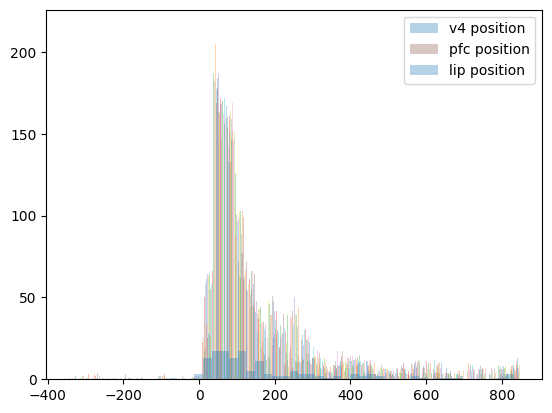

In [10]:
# plt.hist(lat_rand_v4_position-350, bins=40,label="v4 position", alpha=0.33)
# plt.hist(lat_rand_pfc_position-350, bins=40,label="pfc position", alpha=0.33)
# plt.hist(lat_lip_position-350, bins=40,label="lip position", alpha=0.33)
# plt.legend()

In [138]:

count_lip_neutral, bins_count = np.histogram(lat_lip_neutral[np.logical_and(lat_lip_neutral>0, lat_lip_neutral< 1200)], bins=30) 
pdf_lip_neutral = count_lip_neutral #/ sum(count_lip_neutral) 
cdf_lip_neutral = np.cumsum(pdf_lip_neutral) 
pdfn_lip_neutral = count_lip_neutral / sum(count_lip_neutral) 
cdfn_lip_neutral = np.cumsum(pdfn_lip_neutral) 

count_lip_orient, bins_count = np.histogram(lat_lip_orient[np.logical_and(lat_lip_orient>0, lat_lip_orient< 1200)], bins=30) 
pdf_lip_orient = count_lip_orient #/ sum(count_lip_orient) 
cdf_lip_orient = np.cumsum(pdf_lip_orient) 
pdfn_lip_orient = count_lip_orient / sum(count_lip_orient) 
cdfn_lip_orient = np.cumsum(pdfn_lip_orient) 

count_lip_color, bins_count = np.histogram(lat_lip_color[np.logical_and(lat_lip_color>0, lat_lip_color< 1200)], bins=30) 
pdf_lip_color = count_lip_color #/ sum(count_lip_color) 
cdf_lip_color = np.cumsum(pdf_lip_color) 
pdfn_lip_color = count_lip_color / sum(count_lip_color) 
cdfn_lip_color = np.cumsum(pdfn_lip_color) 

count_lip_position  =   np.zeros((1000, 30))
count_lip_neutral   =   np.zeros((1000, 30))
count_lip_orient    =   np.zeros((1000, 30))
count_lip_color     =   np.zeros((1000, 30))

count_pfc_position  =   np.zeros((1000, 30))
count_pfc_neutral   =   np.zeros((1000, 30))
count_pfc_orient    =   np.zeros((1000, 30))
count_pfc_color     =   np.zeros((1000, 30))

count_v4_position   =   np.zeros((1000, 30))
count_v4_neutral    =   np.zeros((1000, 30))
count_v4_orient     =   np.zeros((1000, 30))
count_v4_color      =   np.zeros((1000, 30))

bins_count          =   np.zeros((1000, 31))

for j in range(1000):
    count_lip_position[j], bins_count[j]    =   np.histogram(lat_rand_lip_position[j,np.where(lat_rand_lip_position[j]>0)], bins=30, range=[0, 1200])
    count_lip_neutral[j], bins_count[j]     =   np.histogram(lat_rand_lip_neutral[j,np.where(lat_rand_lip_neutral[j]>0)], bins=30, range=[0, 1200])
    count_lip_orient[j], bins_count[j]      =   np.histogram(lat_rand_lip_orient[j,np.where(lat_rand_lip_orient[j]>0)], bins=30, range=[0, 1200])
    count_lip_color[j], bins_count[j]       =   np.histogram(lat_rand_lip_color[j,np.where(lat_rand_lip_color[j]>0)], bins=30, range=[0, 1200])

    count_pfc_position[j], bins_count[j]    =   np.histogram(lat_rand_pfc_position[j,np.where(lat_rand_pfc_position[j]>0)], bins=30, range=[0, 1200])
    count_pfc_neutral[j], bins_count[j]     =   np.histogram(lat_rand_pfc_neutral[j,np.where(lat_rand_pfc_neutral[j]>0)], bins=30, range=[0, 1200])
    count_pfc_orient[j], bins_count[j]      =   np.histogram(lat_rand_pfc_orient[j,np.where(lat_rand_pfc_orient[j]>0)], bins=30, range=[0, 1200])
    count_pfc_color[j], bins_count[j]       =   np.histogram(lat_rand_pfc_color[j,np.where(lat_rand_pfc_color[j]>0)], bins=30, range=[0, 1200])


    count_v4_position[j], bins_count[j]     =   np.histogram(lat_rand_v4_position[j,np.where(lat_rand_v4_position[j]>0)], bins=30, range=[0, 1200])
    count_v4_neutral[j], bins_count[j]      =   np.histogram(lat_rand_v4_neutral[j,np.where(lat_rand_v4_neutral[j]>0)], bins=30, range=[0, 1200])
    count_v4_orient[j], bins_count[j]       =   np.histogram(lat_rand_v4_orient[j,np.where(lat_rand_v4_orient[j]>0)], bins=30, range=[0, 1200])
    count_v4_color[j], bins_count[j]        =   np.histogram(lat_rand_v4_color[j,np.where(lat_rand_v4_color[j]>0)], bins=30, range=[0, 1200])


pdf_lip_position    =   count_lip_position #/ sum(count_lip_position) 
cdf_lip_position    =   np.cumsum(pdf_lip_position, axis=1) 

pdfn_lip_position   =   [np.transpose(count_lip_position) / np.sum(count_lip_position, axis=1)][0] 
cdfn_lip_position   =   np.cumsum(pdfn_lip_position, axis=0) 

pdf_lip_neutral     =   count_lip_neutral #/ sum(count_lip_neutral) 
cdf_lip_neutral     =   np.cumsum(pdf_lip_neutral, axis=1) 
pdfn_lip_neutral    =   [np.transpose(count_lip_neutral) / np.sum(count_lip_neutral, axis=1)][0] 
cdfn_lip_neutral    =   np.cumsum(pdfn_lip_neutral, axis=0)  

pdf_lip_orient      =   count_lip_orient #/ sum(count_lip_orient) 
cdf_lip_orient      =   np.cumsum(pdf_lip_orient, axis=1) 
pdfn_lip_orient     =   [np.transpose(count_lip_orient) / np.sum(count_lip_orient, axis=1)][0]
cdfn_lip_orient     =   np.cumsum(pdfn_lip_orient, axis=0)     

pdf_lip_color       =   count_lip_color #/ sum(count_lip_color) 
cdf_lip_color       =   np.cumsum(pdf_lip_color, axis=1) 
pdfn_lip_color      =   [np.transpose(count_lip_color) / np.sum(count_lip_color, axis=1)][0]
cdfn_lip_color      =   np.cumsum(pdfn_lip_color, axis=0)  

pdf_pfc_position    =   count_pfc_position #/ sum(count_pfc_position) 
cdf_pfc_position    =   np.cumsum(pdf_pfc_position, axis=1) 
pdfn_pfc_position   =   [np.transpose(count_pfc_position) / np.sum(count_pfc_position, axis=1) ][0]
cdfn_pfc_position   =   np.cumsum(pdfn_pfc_position, axis=0)  

pdf_pfc_neutral     =   count_pfc_neutral #/ sum(count_pfc_neutral) 
cdf_pfc_neutral     =   np.cumsum(pdf_pfc_neutral, axis=1) 
pdfn_pfc_neutral    =   [np.transpose(count_pfc_neutral) / np.sum(count_pfc_neutral, axis=1) ][0]
cdfn_pfc_neutral    =   np.cumsum(pdfn_pfc_neutral, axis=0)  

pdf_pfc_orient      =   count_pfc_orient #/ sum(count_pfc_orient) 
cdf_pfc_orient      =   np.cumsum(pdf_pfc_orient, axis=1) 
pdfn_pfc_orient     =   [np.transpose(count_pfc_orient) / np.sum(count_pfc_orient, axis=1)][0]
cdfn_pfc_orient     =   np.cumsum(pdfn_pfc_orient, axis=0)    

pdf_pfc_color       =   count_pfc_color #/ sum(count_pfc_color) 
cdf_pfc_color       =   np.cumsum(pdf_pfc_color, axis=1) 
pdfn_pfc_color      =   [np.transpose(count_pfc_color) / np.sum(count_pfc_color, axis=1) ][0]
cdfn_pfc_color      =   np.cumsum(pdfn_pfc_color, axis=0)  


pdf_v4_position    =   count_v4_position #/ sum(count_v4_position) 
cdf_v4_position    =   np.cumsum(pdf_v4_position, axis=1) 
pdfn_v4_position   =   np.transpose(count_v4_position) / np.sum(count_v4_position, axis=1) 
cdfn_v4_position   =   np.cumsum(pdfn_v4_position, axis=0) 

pdf_v4_neutral     =   count_v4_neutral #/ sum(count_v4_neutral) 
cdf_v4_neutral     =   np.cumsum(pdf_v4_neutral, axis=1) 
pdfn_v4_neutral    =   np.transpose(count_v4_neutral) / np.sum(count_v4_neutral, axis=1) 
cdfn_v4_neutral    =   np.cumsum(pdfn_v4_neutral, axis=0) 

pdf_v4_orient      =   count_v4_orient #/ sum(count_v4_orient) 
cdf_v4_orient      =   np.cumsum(pdf_v4_orient, axis=1) 
pdfn_v4_orient     =   np.transpose(count_v4_orient) / np.sum(count_v4_orient, axis=1) 
cdfn_v4_orient     =   np.cumsum(pdfn_v4_orient, axis=0)   

pdf_v4_color       =   count_v4_color #/ sum(count_v4_color) 
cdf_v4_color       =   np.cumsum(pdf_v4_color, axis=1) 
pdfn_v4_color      =   np.transpose(count_v4_color) / np.sum(count_v4_color, axis=1) 
cdfn_v4_color      =   np.cumsum(pdfn_v4_color, axis=0) 


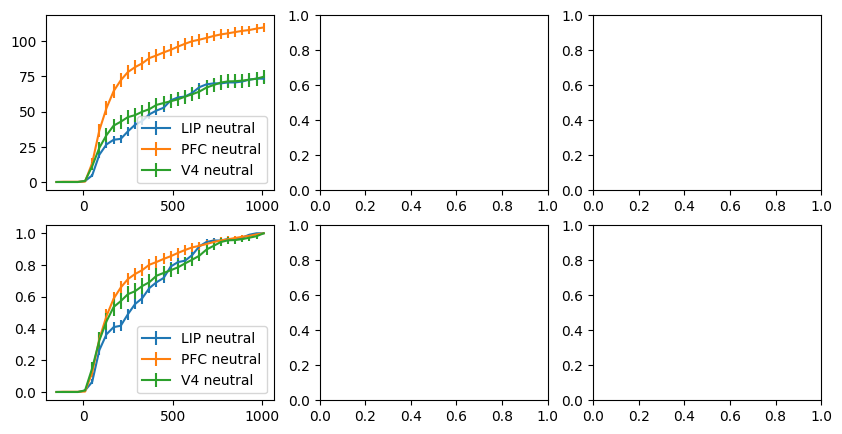

In [139]:
fig, ax      =   plt.subplots(2,3,figsize=(10,5))
ax[0,0].errorbar(bins_count[0][:-1]-150,np.mean(cdf_lip_neutral, axis=0),yerr=np.std(cdf_lip_neutral, axis=0), label="LIP neutral")
ax[0,0].errorbar(bins_count[0][:-1]-150,np.mean(cdf_pfc_neutral, axis=0),yerr=np.std(cdf_pfc_neutral, axis=0), label="PFC neutral")
ax[0,0].errorbar(bins_count[0][:-1]-150,np.mean(cdf_v4_neutral, axis=0),yerr=np.std(cdf_v4_neutral, axis=0), label="V4 neutral")
ax[0,0].legend()    

ax[1,0].errorbar(bins_count[0][:-1]-150,np.mean(cdfn_lip_neutral, axis=1),yerr=np.std(cdfn_lip_neutral, axis=1), label="LIP neutral")
ax[1,0].errorbar(bins_count[0][:-1]-150,np.mean(cdfn_pfc_neutral, axis=1),yerr=np.std(cdfn_pfc_neutral, axis=1), label="PFC neutral")
ax[1,0].errorbar(bins_count[0][:-1]-150,np.mean(cdfn_v4_neutral, axis=1),yerr=np.std(cdfn_v4_neutral, axis=1), label="V4 neutral")
ax[1,0].legend() 

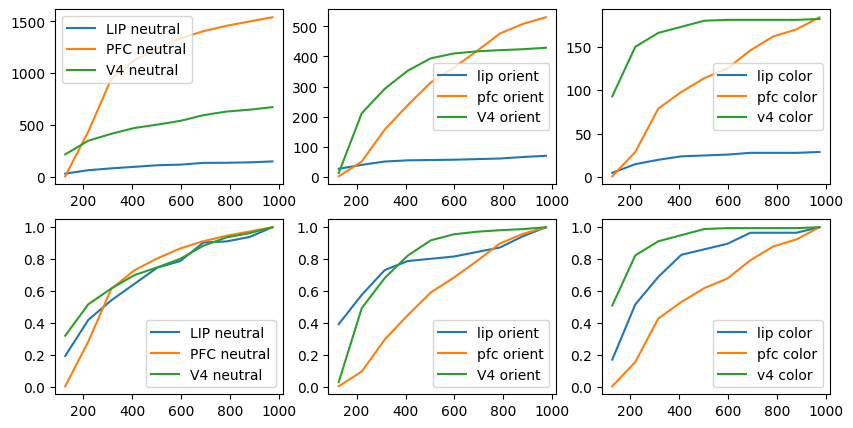

In [49]:
fig, ax      =   plt.subplots(2,3,figsize=(10,5))
count_lip_neutral, bins_count = np.histogram(lat_lip_neutral[np.logical_and(lat_lip_neutral>0, lat_lip_neutral< 1200)], bins=10) 
pdf_lip_neutral = count_lip_neutral #/ sum(count_lip_neutral) 
cdf_lip_neutral = np.cumsum(pdf_lip_neutral) 
pdfn_lip_neutral = count_lip_neutral / sum(count_lip_neutral) 
cdfn_lip_neutral = np.cumsum(pdfn_lip_neutral) 

count_lip_orient, bins_count = np.histogram(lat_lip_orient[np.logical_and(lat_lip_orient>0, lat_lip_orient< 1200)], bins=10) 
pdf_lip_orient = count_lip_orient #/ sum(count_lip_orient) 
cdf_lip_orient = np.cumsum(pdf_lip_orient) 
pdfn_lip_orient = count_lip_orient / sum(count_lip_orient) 
cdfn_lip_orient = np.cumsum(pdfn_lip_orient) 

count_lip_color, bins_count = np.histogram(lat_lip_color[np.logical_and(lat_lip_color>0, lat_lip_color< 1200)], bins=10) 
pdf_lip_color = count_lip_color #/ sum(count_lip_color) 
cdf_lip_color = np.cumsum(pdf_lip_color) 
pdfn_lip_color = count_lip_color / sum(count_lip_color) 
cdfn_lip_color = np.cumsum(pdfn_lip_color) 


count_pfc_neutral, bins_count = np.histogram(lat_pfc_neutral[np.logical_and(lat_pfc_neutral>0, lat_pfc_neutral< 1200)], bins=10) 
pdf_pfc_neutral = count_pfc_neutral #/ sum(count_pfc_neutral) 
cdf_pfc_neutral = np.cumsum(pdf_pfc_neutral) 
pdfn_pfc_neutral= count_pfc_neutral / sum(count_pfc_neutral) 
cdfn_pfc_neutral= np.cumsum(pdfn_pfc_neutral) 

count_pfc_orient, bins_count = np.histogram(lat_pfc_orient[np.logical_and(lat_pfc_orient>0, lat_pfc_orient< 1200)], bins=10) 
pdf_pfc_orient = count_pfc_orient #/ sum(count_pfc_orient) 
cdf_pfc_orient = np.cumsum(pdf_pfc_orient) 
pdfn_pfc_orient= count_pfc_orient / sum(count_pfc_orient) 
cdfn_pfc_orient= np.cumsum(pdfn_pfc_orient) 

count_pfc_color, bins_count = np.histogram(lat_pfc_color[np.logical_and(lat_pfc_color>0, lat_pfc_color< 1200)], bins=10) 
pdf_pfc_color = count_pfc_color #/ sum(count_pfc_color) 
cdf_pfc_color = np.cumsum(pdf_pfc_color) 
pdfn_pfc_color = count_pfc_color / sum(count_pfc_color) 
cdfn_pfc_color= np.cumsum(pdfn_pfc_color) 

count_v4_neutral, bins_count = np.histogram(lat_v4_neutral[np.logical_and(lat_v4_neutral>0, lat_v4_neutral< 1200)], bins=10) 
pdf_v4_neutral = count_v4_neutral #/ sum(count_v4_neutral) 
cdf_v4_neutral = np.cumsum(pdf_v4_neutral) 
pdfn_v4_neutral = count_v4_neutral / sum(count_v4_neutral) 
cdfn_v4_neutral = np.cumsum(pdfn_v4_neutral) 

count_v4_orient, bins_count = np.histogram(lat_v4_orient[np.logical_and(lat_v4_orient>0, lat_v4_orient< 1200)], bins=10) 
pdf_v4_orient = count_v4_orient #/ sum(count_v4_orient) 
cdf_v4_orient = np.cumsum(pdf_v4_orient) 
pdfn_v4_orient = count_v4_orient / sum(count_v4_orient) 
cdfn_v4_orient = np.cumsum(pdfn_v4_orient) 

count_v4_color, bins_count = np.histogram(lat_v4_color[np.logical_and(lat_v4_color>0, lat_v4_color< 1200)], bins=10) 
pdf_v4_color = count_v4_color #/ sum(count_v4_color) 
cdf_v4_color = np.cumsum(pdf_v4_color) 
pdfn_v4_color = count_v4_color / sum(count_v4_color) 
cdfn_v4_color = np.cumsum(pdfn_v4_color) 

ax[0,0].plot(bins_count[1:]-150, cdf_lip_neutral, label="LIP neutral") 
ax[0,0].plot(bins_count[1:]-150, cdf_pfc_neutral, label="PFC neutral") 
ax[0,0].plot(bins_count[1:]-150, cdf_v4_neutral, label="V4 neutral") 
ax[0,0].legend()    


ax[1,0].plot(bins_count[1:]-150, cdfn_lip_neutral, label="LIP neutral") 
ax[1,0].plot(bins_count[1:]-150, cdfn_pfc_neutral, label="PFC neutral") 
ax[1,0].plot(bins_count[1:]-150, cdfn_v4_neutral, label="V4 neutral") 
ax[1,0].legend()    

# ax[1,0].boxplot([lat_lip_neutral[np.logical_and(lat_lip_neutral>0, lat_lip_neutral< 1200)]-400, 
#                 lat_pfc_neutral[np.logical_and(lat_pfc_neutral>0, lat_pfc_neutral< 1200)]-400,
#                 lat_v4_neutral[np.logical_and(lat_v4_neutral>0, lat_v4_neutral< 1200)]-400])



ax[0,1].plot(bins_count[1:]-150, cdf_lip_orient, label="lip orient") 
ax[0,1].plot(bins_count[1:]-150, cdf_pfc_orient, label="pfc orient") 
ax[0,1].plot(bins_count[1:]-150, cdf_v4_orient, label="V4 orient") 
ax[0,1].legend()    

ax[1,1].plot(bins_count[1:]-150, cdfn_lip_orient, label="lip orient") 
ax[1,1].plot(bins_count[1:]-150, cdfn_pfc_orient, label="pfc orient") 
ax[1,1].plot(bins_count[1:]-150, cdfn_v4_orient, label="V4 orient") 
ax[1,1].legend()    


# ax[1,1].boxplot([lat_lip_orient[np.logical_and(lat_lip_orient>0, lat_lip_orient< 1200)]-400,
#                 lat_pfc_orient[np.logical_and(lat_pfc_orient>0, lat_pfc_orient< 1200)]-400,
#                 lat_v4_orient[np.logical_and(lat_v4_orient>0, lat_v4_orient< 1200)]-400])


ax[0,2].plot(bins_count[1:]-150, cdf_lip_color, label="lip color") 
ax[0,2].plot(bins_count[1:]-150, cdf_pfc_color, label="pfc color") 
ax[0,2].plot(bins_count[1:]-150, cdf_v4_color, label="v4 color") 
ax[0,2].legend() 


ax[1,2].plot(bins_count[1:]-150, cdfn_lip_color, label="lip color") 
ax[1,2].plot(bins_count[1:]-150, cdfn_pfc_color, label="pfc color") 
ax[1,2].plot(bins_count[1:]-150, cdfn_v4_color, label="v4 color") 
ax[1,2].legend() 

# ax[1,2].boxplot([lat_lip_color[np.logical_and(lat_lip_color>0, lat_lip_color< 1200)]-400,
#                 lat_pfc_color[np.logical_and(lat_pfc_color>0, lat_pfc_color< 1200)]-400,
#                 lat_v4_color[np.logical_and(lat_v4_color>0, lat_v4_color< 1200)]-400])

In [63]:
# Use these variables

lnv4=lat_v4_neutral[np.logical_and(lat_v4_neutral>0, lat_v4_neutral< 1200)]-150
lnpfc=lat_pfc_neutral[np.logical_and(lat_pfc_neutral>0, lat_pfc_neutral< 1200)]-150
lnlip=lat_lip_neutral[np.logical_and(lat_lip_neutral>0, lat_lip_neutral< 1200)]-150



lcv4=lat_v4_color[np.logical_and(lat_v4_color>0, lat_v4_color< 1200)]-150
lcpfc=lat_pfc_color[np.logical_and(lat_pfc_color>0, lat_pfc_color< 1200)]-150
lclip=lat_lip_color[np.logical_and(lat_lip_color>0, lat_lip_color< 1200)]-150


lov4=lat_v4_orient[np.logical_and(lat_v4_orient>0, lat_v4_orient< 1200)]-150
lopfc=lat_pfc_orient[np.logical_and(lat_pfc_orient>0, lat_pfc_orient< 1200)]-150
lolip=lat_lip_orient[np.logical_and(lat_lip_orient>0, lat_lip_orient< 1200)]-150

lpv4=lat_v4_position[np.logical_and(lat_v4_position>0, lat_v4_position< 1200)]-150
lppfc=lat_pfc_position[np.logical_and(lat_pfc_position>0, lat_pfc_position< 1200)]-150
lplip=lat_lip_position[np.logical_and(lat_lip_position>0, lat_lip_position< 1200)]-150

stats.ttest_ind(lolip, lopfc)


Ttest_indResult(statistic=-3.7984849007807235, pvalue=0.00016043697425066717)

In [64]:
print(['lip neutral=', np.mean(lnlip)])
print(['pfc neutral=', np.mean(lnpfc)])
print(['v4 neutral=', np.mean(lnv4)])

['lip neutral=', 368.6986301369863]
['pfc neutral=', 284.7038961038961]
['v4 neutral=', 343.03129657228016]


In [65]:
print(['lip orient=', np.mean(lolip)])
print(['pfc orient=', np.mean(lopfc)])
print(['v4 orient=', np.mean(lov4)])

['lip orient=', 295.23943661971833]
['pfc orient=', 427.188679245283]
['v4 orient=', 215.27972027972027]


In [66]:
print(['lip color=', np.mean(lclip)])
print(['pfc color=', np.mean(lcpfc)])
print(['v4 color=', np.mean(lcv4)])

['lip color=', 217.51724137931035]
['pfc color=', 414.92934782608694]
['v4 color=', 156.6813186813187]


In [67]:
print(['lip position=', np.mean(lplip)])
print(['pfc position=', np.mean(lppfc)])
print(['v4 position=', np.mean(lpv4)])

['lip position=', 208.44594594594594]
['pfc position=', 193.62706480304956]
['v4 position=', 233.0350535540409]


<BarContainer object of 12 artists>

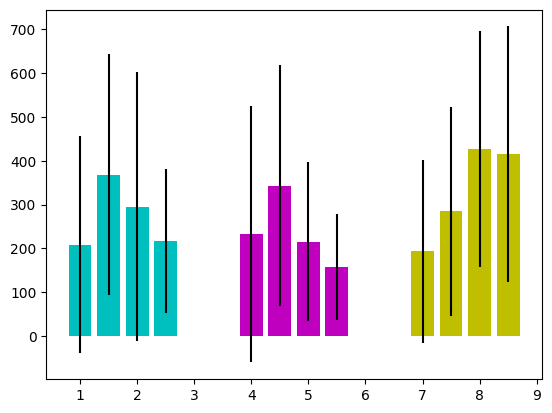

In [97]:
meanValueslip   =   [np.mean(lplip),np.mean(lnlip),np.mean(lolip), np.mean(lclip)]
meanValuesv4    =   [np.mean(lpv4),np.mean(lnv4),np.mean(lov4), np.mean(lcv4)]
meanValuespfc   =   [np.mean(lppfc),np.mean(lnpfc),np.mean(lopfc), np.mean(lcpfc)]

stdValueslip   =   [np.std(lplip),np.std(lnlip),np.std(lolip), np.std(lclip)]
stdValuesv4    =   [np.std(lpv4),np.std(lnv4),np.std(lov4), np.std(lcv4)]
stdValuespfc   =   [np.std(lppfc),np.std(lnpfc),np.std(lopfc), np.std(lcpfc)]

plt.bar([1,1.5,2,2.5, 4,4.5,5,5.5, 7,7.5, 8, 8.5],np.concatenate([meanValueslip,meanValuesv4, meanValuespfc]), yerr=np.concatenate([stdValueslip, stdValuesv4, stdValuespfc]), width=0.4, color=('c','c','c','c', 'm','m','m','m', 'y','y','y','y'))

# FOR ALEXIS TO THINK ABOUT. How to compare those latencies
# plt.errorbar([1,1.5,2,2.5, 4,4.5,5,5.5, 7,7.5, 8, 8.5],[np.std(lplip),np.std(lnlip),np.std(lolip), np.std(lclip),np.std(lpv4),np.std(lnv4),np.std(lov4), np.std(lcv4), np.std(lppfc),np.std(lnpfc),np.std(lopfc), np.std(lcpfc)], yerr=True)

In [146]:
lplip

NameError: name 'lplip' is not defined

In [ ]:
# DECODING